## Imports

In [ ]:
import os
import sys
import pandas as pd
import sys
import altair as alt
import numpy as np
import pickle
from matplotlib import pyplot
import ipywidgets as widgets
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import settings as project_settings

In [ ]:
# If not installed shap uncomment next line

# !pip install shap
import shap

# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 358kB 28.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=da98cf0e7debee91db02d1025f95a064d73ea90657f1853e96ef3c3e4eb1192e
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
# If you are working on Google Colab uncomment next 2 lines

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sns.set_style("darkgrid")

In [ ]:
data_folder = project_settings.data_folder
results_folder = project_settings.results_folder
class_folder = project_settings.class_folder

In [ ]:
sys_min = sys.float_info.min
target_data_folder = f'{data_folder}Regression_target_data/'
features_data_folder = f'{data_folder}Original_folds/'
export_folder = f'{results_folder}export_csv/'
labels =pd.read_csv(f"{target_data_folder}labels.txt",sep=';',index_col=False)
sys_min = sys.float_info.min
mae_folder = f'{results_folder}mae/'
predictions_folder = f'{results_folder}predictions/'
models_folder = f'{results_folder}models/'
multi_target_folder = 'multi_target_output/'
single_output_folder = 'single_output_models/'
regression = 'nn/'
regression_single = 'nn/'
regression_multi = 'nn/'
algorithm_no = 0
algorithm_folder = f'alg_no_{algorithm_no}/'
fold = 0

In [ ]:
import sys
sys.path.append(class_folder)

### Folder init

In [ ]:
shap_function_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_shaps/{regression_multi}precision/'
shap_algorithm_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_shaps/{regression_multi}precision/'
mae_funtion_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_mae/{regression_multi}precision/'
mae_algorithm_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_mae/{regression_multi}precision/'

In [ ]:
os.makedirs(shap_function_level_folder_multi_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_multi_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_multi_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_multi_precision, exist_ok=True)

In [ ]:
shap_function_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_shaps/{regression_multi}log_precision/'
shap_algorithm_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_shaps/{regression_multi}log_precision/'
mae_funtion_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_mae/{regression_multi}log_precision/'
mae_algorithm_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_mae/{regression_multi}log_precision/'

In [ ]:
os.makedirs(shap_function_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_multi_log_precision, exist_ok=True)

In [ ]:
shap_function_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_shaps/{regression_single}precision/'
shap_algorithm_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_shaps/{regression_single}precision/'
mae_funtion_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_mae/{regression_single}precision/'
mae_algorithm_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_mae/{regression_single}precision/'

In [ ]:
os.makedirs(shap_function_level_folder_single_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_single_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_single_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_single_precision, exist_ok=True)

In [ ]:
shap_function_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_shaps/{regression_single}log_precision/'
shap_algorithm_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_shaps/{regression_single}log_precision/'
mae_funtion_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_mae/{regression_single}log_precision/'
mae_algorithm_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_mae/{regression_single}log_precision/'

In [ ]:
os.makedirs(shap_function_level_folder_single_log_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_single_log_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_single_log_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_single_log_precision, exist_ok=True)

## Helper Functions

In [ ]:
def create_data(df,df_perf,labels):
    df2 = df_perf.assign(label = labels['x'])
    df2 = df2.rename(columns={'1' : 'Precision'})
    data = df.join(df2.set_index('label'))
    
    return data

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df = df[df.replace([-np.inf], sys.float_info.min).notnull().all(axis=1)]
    
    return df[indices_to_keep].astype(np.float32)

In [ ]:
def get_data_for_algorith(algorithm, no_fold):
  df_perf = pd.read_csv(f"{target_data_folder}performance_0_I{algorithm}.txt",sep='\t')
  df_train = pd.read_csv(f"{features_data_folder}train_{no_fold}_fused.csv",sep='\t', index_col=0)
  df_test = pd.read_csv(f"{features_data_folder}test_{no_fold}_fused.csv",sep='\t', index_col=0)
  df_perf = df_perf.iloc[:,2:3]

  rez_test = create_data(df_test,df_perf,labels)
  rez_train = create_data(df_train,df_perf,labels)
  
  return rez_train, rez_test

In [ ]:
# Check valid data
def valid_data(df):
  if len(df[df.isin([np.nan, np.inf, -np.inf]).any(1)]) == 0:
    return True
  else:
    return False

In [ ]:
def add_log_performance(df):
  df['log_Precision'] = np.log10(df.iloc[:, -1]+1)
  
  return df

In [ ]:
def get_data(algorithm_no, fold):
  train_df, test_df = get_data_for_algorith(algorithm_no, fold)

  train_df_with_log = add_log_performance(train_df)
  test_df_with_log = add_log_performance(test_df) 

  train_df_with_log_clean = clean_dataset(train_df_with_log)
  test_df_with_log_clean = clean_dataset(test_df_with_log)  

  if valid_data(train_df_with_log_clean) and valid_data(test_df_with_log_clean):
      X_train = train_df_with_log_clean.iloc[:, :-2]
      y_train_labels = train_df_with_log_clean.iloc[:, -2:]

      X_test = test_df_with_log_clean.iloc[:, :-2]
      y_test_labels = test_df_with_log_clean.iloc[:, -2:]

      return X_train, y_train_labels, X_test, y_test_labels
  else:
    raise Exception("Invalid Data")

In [ ]:
def get_dictonary_function_id_with_index(df):
  index = list(df.index)
  fid_index_dict = {}
  functions_order = []
  for fid in index:
    f = fid.split('_')[0]
    fid_index = index.index(fid)
    functions_order.append(f)

    if f in fid_index_dict:
      index_list = fid_index_dict.get(f)
      index_list.append(fid_index)
    
    else:
      fid_index_dict[f] = [fid_index]

  return fid_index_dict, functions_order



In [ ]:
mae_multi_target = pd.read_csv(f'{mae_folder}{multi_target_folder}{regression}mae_alg_no_{algorithm_no}_multi_output_model.csv')
mae_single_output = pd.read_csv(f'{mae_folder}{single_output_folder}{regression}mae_alg_no_{algorithm_no}_single_output_models.csv')

In [ ]:
test_dfs_multioutput = []
test_dfs_singleoutput = []

In [ ]:
algorithm_folder = f'predictions_alg_no_{algorithm_no}/'
predictions_multioutput = os.listdir(predictions_folder + algorithm_folder +  multi_target_folder + regression_multi)
pwd_folder = predictions_folder + algorithm_folder + multi_target_folder + regression_multi
for prediction in predictions_multioutput:
  prediction_df = pd.read_csv(pwd_folder + prediction)
  test_dfs_multioutput.append(prediction_df)


predictions_singleoutput = os.listdir(predictions_folder + algorithm_folder + single_output_folder + regression_single)
pwd_folder = predictions_folder + algorithm_folder + single_output_folder + regression_single
for prediction in predictions_singleoutput:
  prediction_df = pd.read_csv(pwd_folder + prediction)
  test_dfs_singleoutput.append(prediction_df)

In [ ]:
test_multioutput_df = pd.concat(test_dfs_multioutput)
test_singleoutput_df = pd.concat(test_dfs_singleoutput)

In [ ]:
test_multioutput_df.index = test_multioutput_df['Index_col']
test_singleoutput_df.index = test_singleoutput_df['Index_col']

In [ ]:
fid_dict_multi, functions_ids_multi = get_dictonary_function_id_with_index(test_multioutput_df)
fid_dict_single, functions_ids_single = get_dictonary_function_id_with_index(test_singleoutput_df)

In [ ]:
test_multioutput_df['f_id'] = functions_ids_multi
test_singleoutput_df['f_id'] = functions_ids_single

In [ ]:
if 'Precision_real' in test_singleoutput_df.columns.tolist():
  test_singleoutput_df_precision = test_singleoutput_df.loc[test_singleoutput_df['Precision_real'].notna()]
if 'log_Precision_real' in test_singleoutput_df.columns.tolist():
  test_singleoutput_df_log_precision = test_singleoutput_df.loc[test_singleoutput_df['log_Precision_real'].notna()]

In [ ]:
test_singleoutput_df_precision_clean = test_singleoutput_df_precision[['Index_col',	'Algorithm', 'Fold', 'Precision_prediction', 'Precision_real','f_id']]
test_singleoutput_df_log_precision_clean = test_singleoutput_df_log_precision[['Index_col',	'Algorithm', 'Fold', 'log_Precision_prediction', 'log_Precision_real','f_id']]

In [ ]:
test_singleoutput_df_precision_clean.index.name = None
test_singleoutput_df_log_precision_clean.index.name = None
test_multioutput_df.index.name = None
test_singleoutput_df_precision_renamed = test_singleoutput_df_precision_clean.rename(columns={'Precision_prediction': 'Precision_prediction_singletarget', 'Precision_real': 'Precision_real_singletarget'})
test_singleoutput_df_log_precision_renamed = test_singleoutput_df_log_precision_clean.rename(columns={'log_Precision_prediction': 'log_Precision_prediction_singletarget', 'log_Precision_real': 'log_Precision_real_singletarget'})
test_multioutput_df_renamed = test_multioutput_df.rename(columns={'Precision_prediction': 'Precision_prediction_multitarget', 'Precision_real': 'Precision_real', 'log_Precision_prediction': 'log_Precision_prediction_multitarget', 'log_Precision_real':'log_Precision_real', 'f_id':'f_id_multi'})

In [ ]:
single_multi_precision_df = pd.merge(test_singleoutput_df_precision_renamed, test_multioutput_df_renamed, on='Index_col')
single_multi_log_precision_df = pd.merge(test_singleoutput_df_log_precision_renamed, test_multioutput_df_renamed, on='Index_col')

In [ ]:
single_multi_precision_df_melted = pd.melt(single_multi_precision_df, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [ ]:
single_multi_log_precision_df_melted = pd.melt(single_multi_log_precision_df, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [ ]:
single_multi_output = pd.merge(mae_single_output, mae_multi_target, on='Fold')

In [ ]:
single_pivot = pd.pivot_table(mae_single_output, columns='Label', values='MAE', index='Fold')

In [ ]:
single_pivot = single_pivot.reset_index()

In [ ]:
single_pivot_df = pd.DataFrame(single_pivot)

In [ ]:
mae_merged = pd.merge(single_pivot_df, mae_multi_target, on='Fold')

In [ ]:
mae_merged_renamed = mae_merged.rename(columns={'Precision': 'Precision_single_output_mae', 'Precision_mae': 'Precision_multioutput_mae', 'log_Precision': 'log_Precision_single_output_mae', 'log_Precision_mae':'log_Precision_multioutput_mae'})

In [ ]:
mae_merged_renamed['Precision_mae_diff'] = mae_merged_renamed['Precision_multioutput_mae'].sub(mae_merged_renamed['Precision_single_output_mae'], axis=0)
mae_merged_renamed['log_Precision_mae_diff'] = mae_merged_renamed['log_Precision_multioutput_mae'].sub(mae_merged_renamed['log_Precision_single_output_mae'], axis=0)

In [ ]:
mae_precision_dif_mean = np.mean(mae_merged_renamed['Precision_mae_diff'])
mae_log_precision_dif_mean = np.mean(mae_merged_renamed['log_Precision_mae_diff'])

In [ ]:
print(f'Difference in Label: Precision between MAE of Multi Output Model and Single Output Model {mae_precision_dif_mean:.4f}\n')
print(f'Difference in Label: Log Precision between MAE of Multi Output Model and Single Output Model {mae_log_precision_dif_mean:.4f}')

Difference in Label: Precision between MAE of Multi Output Model and Single Output Model -0.0562

Difference in Label: Log Precision between MAE of Multi Output Model and Single Output Model 0.0356


## Load Model

In [ ]:
model_multi = keras.models.load_model(f"{models_folder}{multi_target_folder}{regression}model_fold_no_{fold}_alg_no_{algorithm_no}")
model_single_precision = keras.models.load_model(f"{models_folder}{single_output_folder}{regression}model_fold_no_{fold}_alg_no_{algorithm_no}_label_Precision")
model_single_log_precision = keras.models.load_model(f"{models_folder}{single_output_folder}{regression}model_fold_no_{fold}_alg_no_{algorithm_no}_label_log_Precision")

In [ ]:
X_train, y_train, X_test, y_test = get_data(algorithm_no, fold)

# Visualization

## SHAP

### SHAP Multi Output Model

In [ ]:
explainer = shap.DeepExplainer(model_multi, np.array(X_train))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
shap_values = explainer.shap_values(np.array(X_train))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


#### Precision

Current Label Shown: Precision 



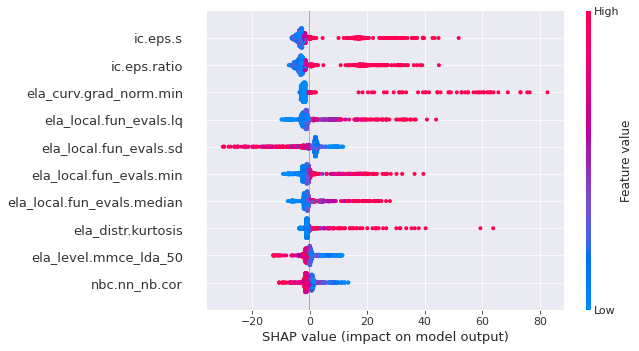

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Precision \n')

shap.summary_plot(shap_values = shap_values[0],
                  features = X_train.iloc[:,:], max_display=10
                  ) 

#### Log Precision

Current Label Shown: Log Precision 



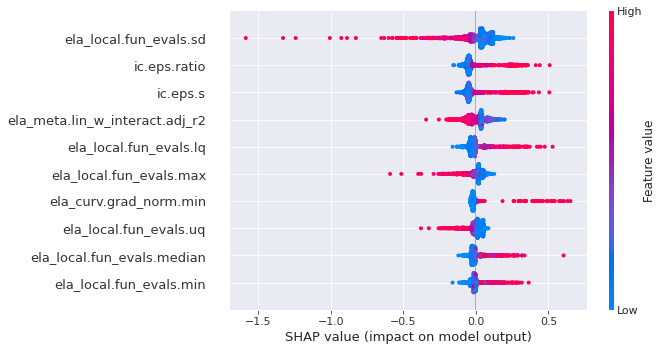

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Log Precision \n')

shap.summary_plot(shap_values = shap_values[1],
                  features = X_train.iloc[:,:], max_display=10
                  ) 

### SHAP Single Output Models

#### Precision

In [ ]:
explainer = shap.DeepExplainer(model_single_precision, np.array(X_train))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
shap_values = explainer.shap_values(np.array(X_train))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Current Label Shown: Precision 



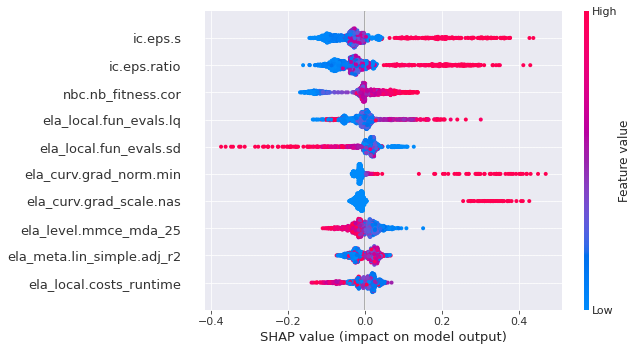

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Precision \n')

shap.summary_plot(shap_values = shap_values[0],
                  features = X_train.iloc[:,:], max_display=10
                  ) 

#### Log Precision

In [ ]:
explainer = shap.DeepExplainer(model_single_log_precision, np.array(X_train))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
shap_values = explainer.shap_values(np.array(X_train))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Current Label Shown: Log Precision 



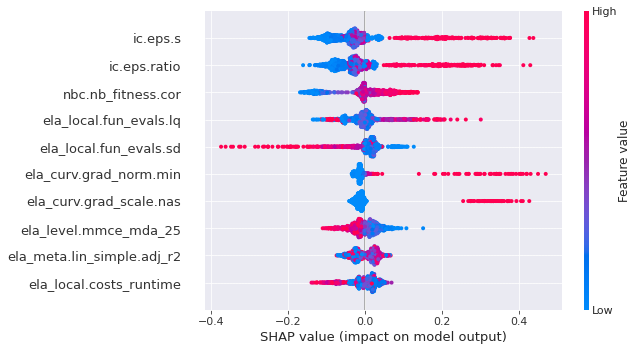

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Log Precision \n')

shap.summary_plot(shap_values = shap_values[0],
                  features = X_train.iloc[:,:], max_display=10
                  ) 

## MAE Single vs Multioutput

In [ ]:
mae_merged_renamed = mae_merged_renamed.rename(columns={'Precision_single_output_mae': 'Precision Single-output MAE', 'Precision_multioutput_mae': 'Precision Multi-output MAE', 'log_Precision_single_output_mae': 'Log Precision Single-output MAE', 'log_Precision_multioutput_mae':'Log Precision Multi-output MAE'})

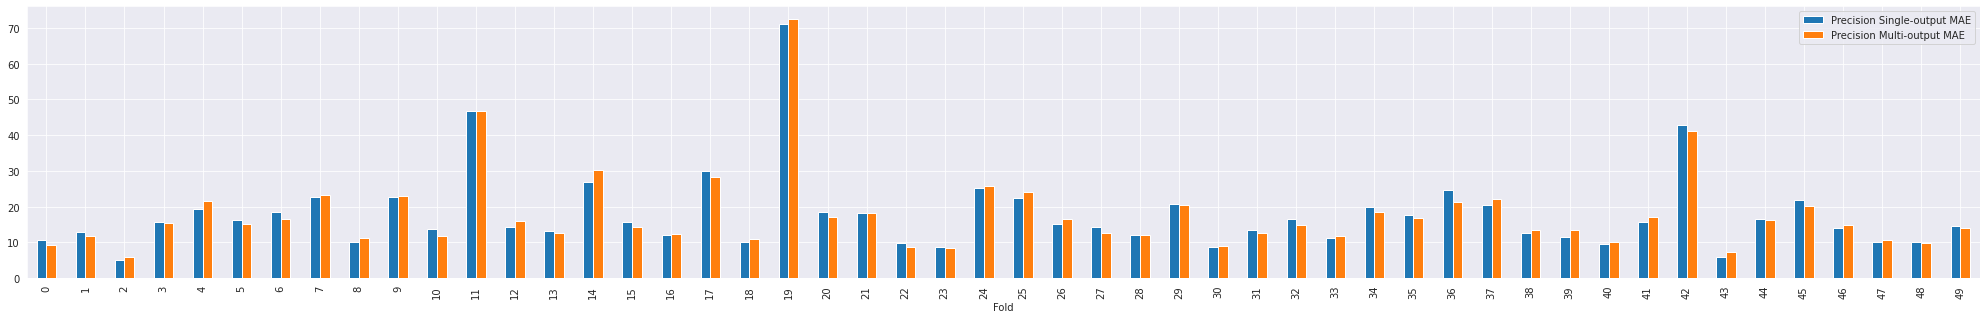

In [ ]:
mae_merged_renamed.plot(x="Fold", y=["Precision Single-output MAE", "Precision Multi-output MAE"], kind="bar", figsize=(35,5), width = 0.5)

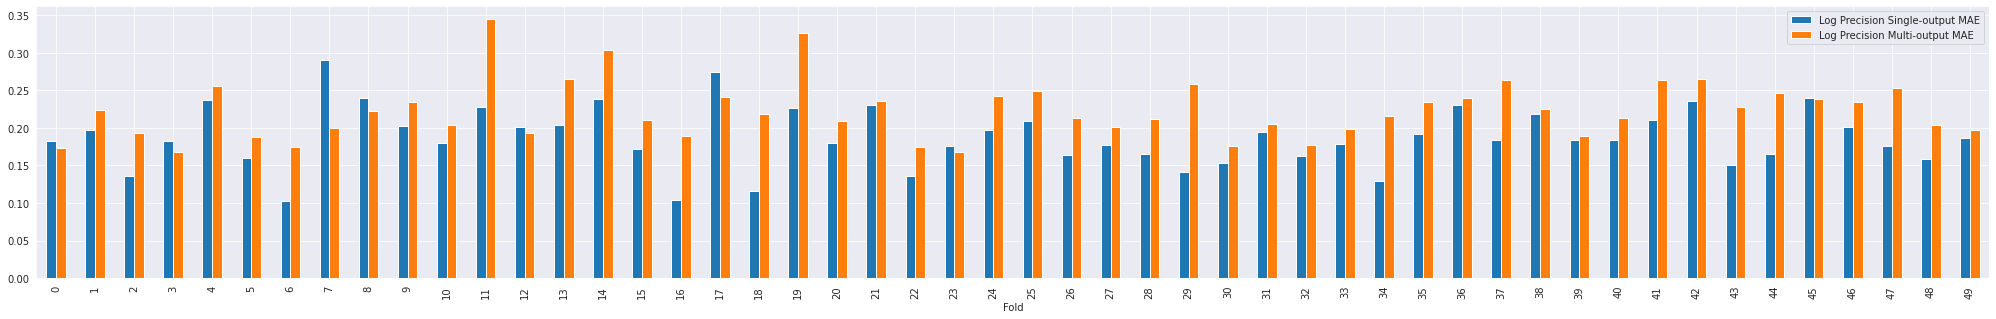

In [ ]:
mae_merged_renamed.plot(x="Fold", y=["Log Precision Single-output MAE", "Log Precision Multi-output MAE"], kind="bar", figsize=(35,5), width = 0.5)

## MAE on function level

### Label: Precision

In [ ]:
mae_fid = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == str(i)][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['Function ID', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION'])

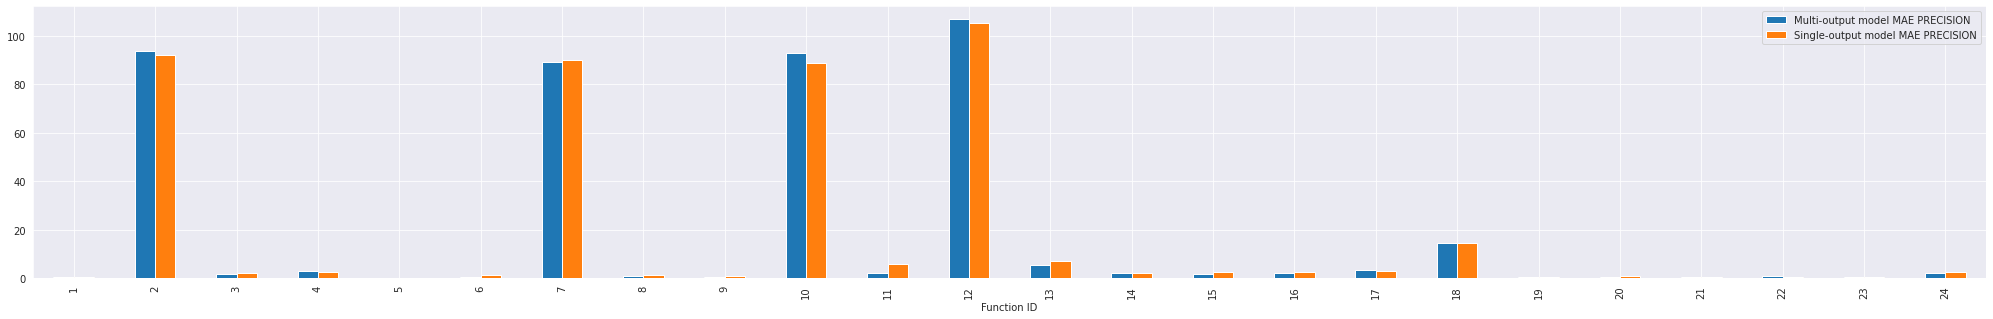

In [ ]:
mae_fid_df.plot(x="Function ID", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

In [ ]:
mae_fid_df_less_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE PRECISION'] < 10) & (mae_fid_df['Single-output model MAE PRECISION'] < 10)]
mae_fid_df_more_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE PRECISION'] >= 10) & (mae_fid_df['Single-output model MAE PRECISION'] >= 10)]

In [ ]:
mae_fid_df_less_10.columns = ['f_id', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION']
mae_fid_df_more_10.columns = ['f_id', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION']

In [ ]:
# mae_fid_df['Multi_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Multi_output_model_MAE_PRECISION'])
# mae_fid_df['Single_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Single_output_model_MAE_PRECISION'])

* Functions with MAE less than 10 

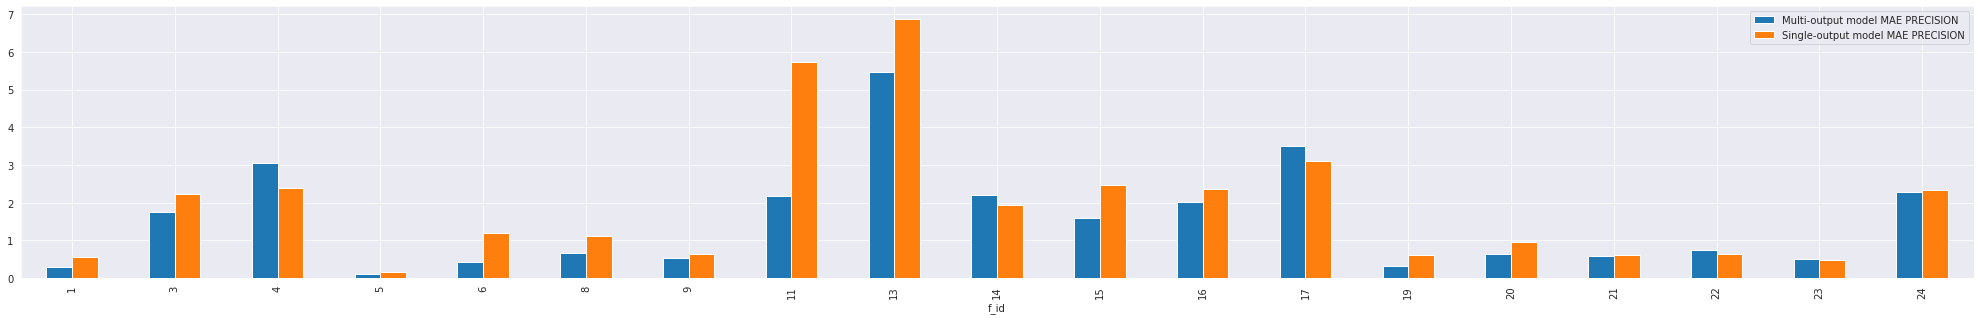

In [ ]:
mae_fid_df_less_10.plot(x="f_id", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

* Functions with MAE more than 10 

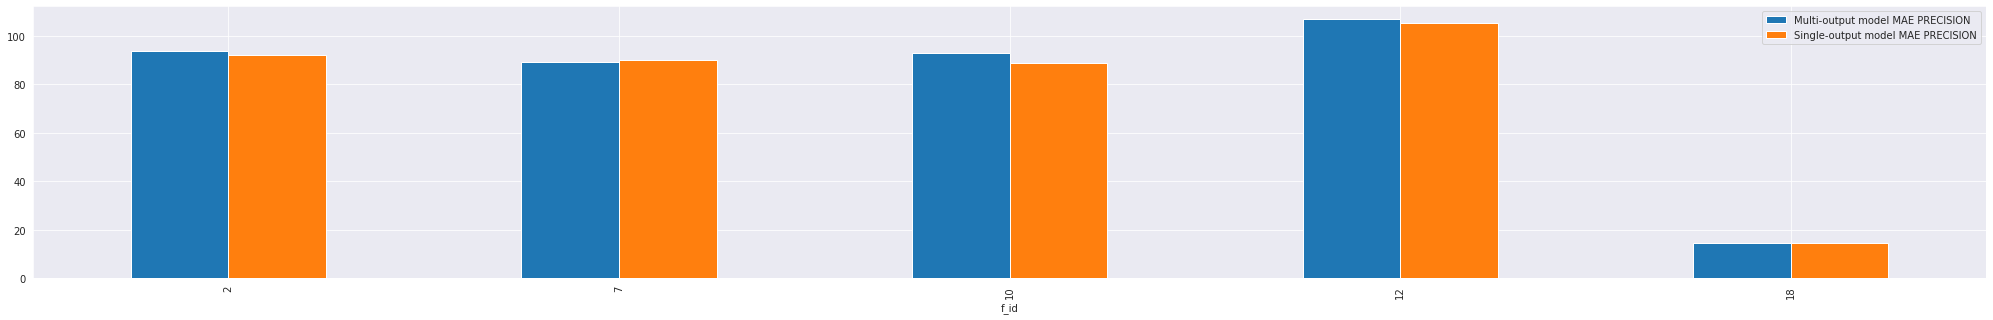

In [ ]:
mae_fid_df_more_10.plot(x="f_id", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

### Label: Log Precision

In [ ]:
mae_fid = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == str(i)][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['Function ID', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION'])

In [ ]:
mae_fid_df_less_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE LOG PRECISION'] < 10) & (mae_fid_df['Single-output model MAE LOG PRECISION'] < 10)]
mae_fid_df_more_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE LOG PRECISION'] >= 10) & (mae_fid_df['Single-output model MAE LOG PRECISION'] >= 10)]

In [ ]:
mae_fid_df_less_10.columns = ['f_id', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION']
mae_fid_df_more_10.columns = ['f_id', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION']

In [ ]:
# mae_fid_df['Multi_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Multi_output_model_MAE_PRECISION'])
# mae_fid_df['Single_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Single_output_model_MAE_PRECISION'])

* Functions with MAE less than 10 

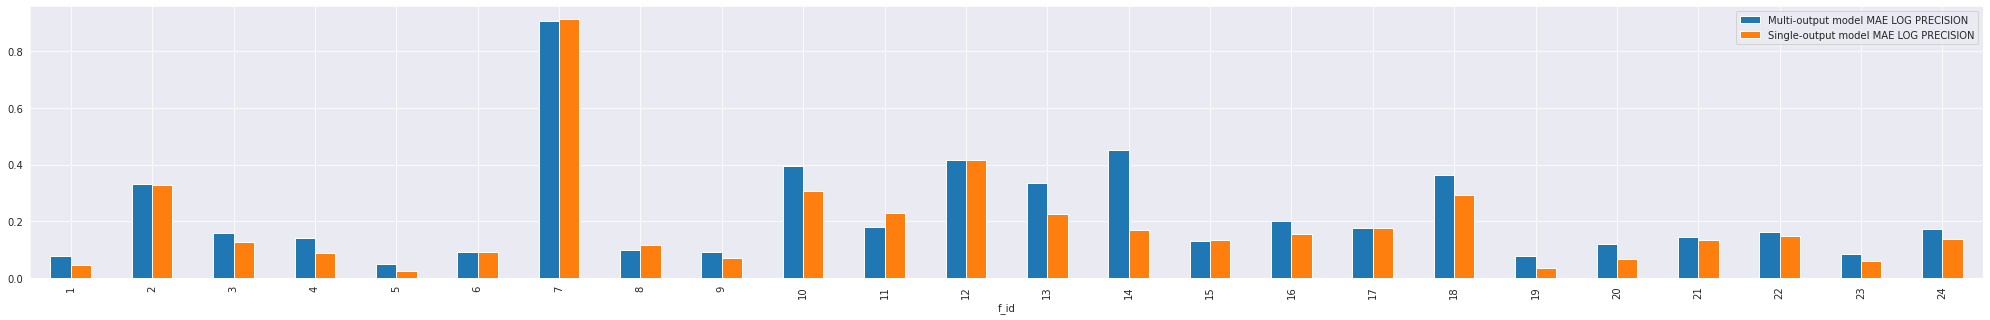

In [ ]:
mae_fid_df_less_10.plot(x="f_id", y=["Multi-output model MAE LOG PRECISION", "Single-output model MAE LOG PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

## Precision

In [ ]:
single_multi_precision_df_melted['value_log'] = np.log(single_multi_precision_df_melted['value'])

divide by zero encountered in log
invalid value encountered in log


In [ ]:
single_multi_precision_df_melted.replace("Precision_prediction_multitarget", 'Precision Predictions Multi-output model', inplace=True)

In [ ]:
single_multi_precision_df_melted.replace("Precision Predictions Multi-output model", 'Predictions Multi-output model', inplace=True)

In [ ]:
single_multi_precision_df_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)

In [ ]:
single_multi_precision_df_melted.replace("Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_precision_df_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

In [ ]:
domain_precision = ['Precision Predictions Multi-output model', 'Precision Predictions Single-output model', 'Precision Real']

In [ ]:
alt.Chart(
    single_multi_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Precision:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

In [ ]:
alt.Chart(
    single_multi_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Precision Log Scale:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

invalid value encountered in double_scalars


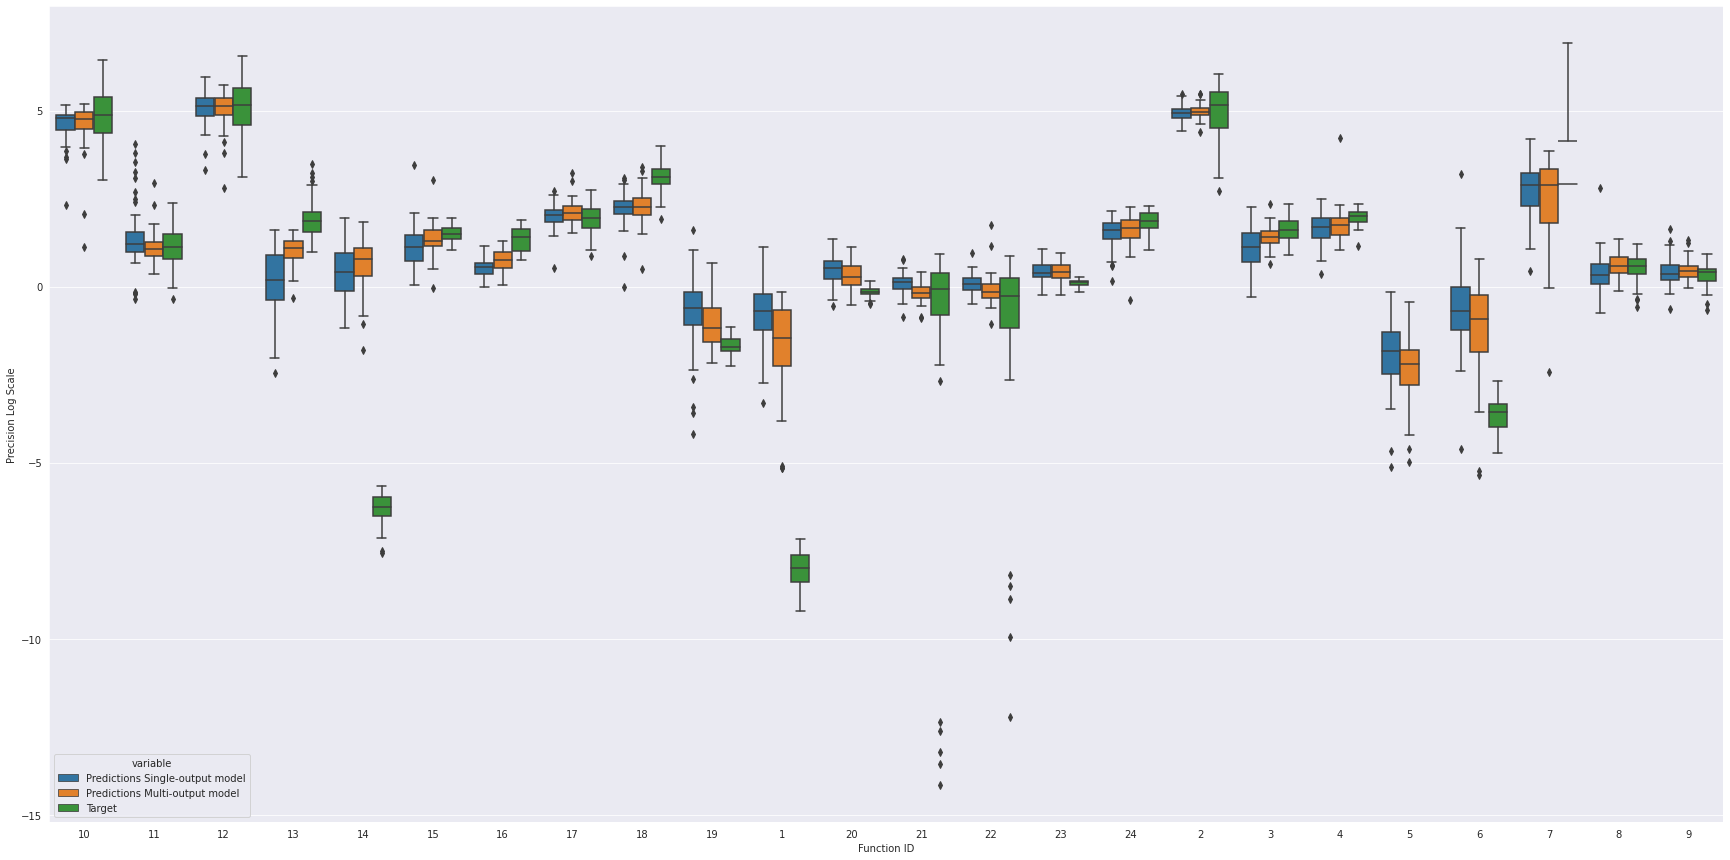

In [ ]:
a4_dims = (30, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_melted)

### Precision for a given function

In [ ]:
f_id = '4'

In [ ]:
single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == f_id][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]

In [ ]:
single_multi_precision_df_f_id_1_melted = pd.melt(single_multi_precision_df_f_id_1, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [ ]:
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_precision_df_f_id_1_melted['value_log'] = np.log(single_multi_precision_df_f_id_1_melted['value'])

In [ ]:
single_multi_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

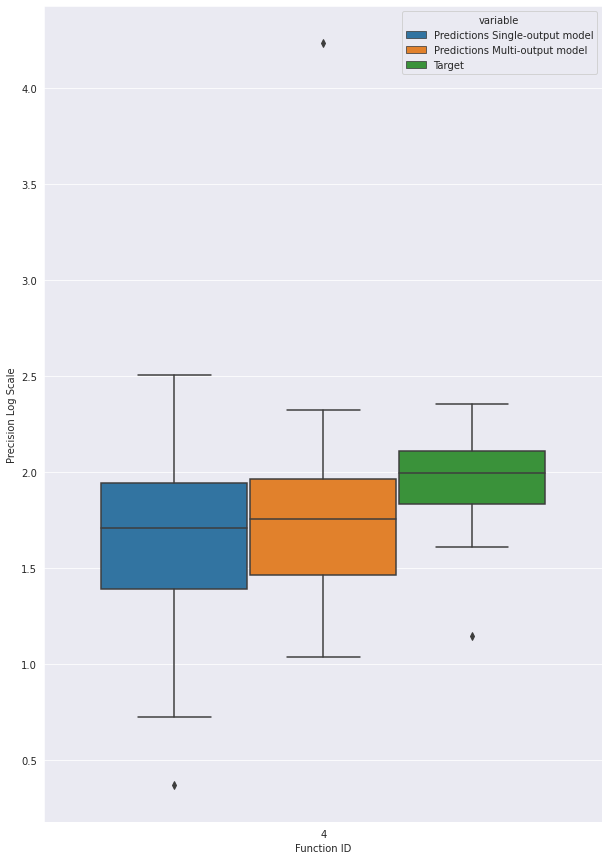

In [ ]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_f_id_1_melted)

In [ ]:
alt.Chart(single_multi_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Precision Log Scale:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

### Precision for a given function

In [ ]:
f_id = '13'

In [ ]:
single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == f_id][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]

In [ ]:
single_multi_precision_df_f_id_1_melted = pd.melt(single_multi_precision_df_f_id_1, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [ ]:
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_precision_df_f_id_1_melted['value_log'] = np.log(single_multi_precision_df_f_id_1_melted['value'])

In [ ]:
single_multi_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

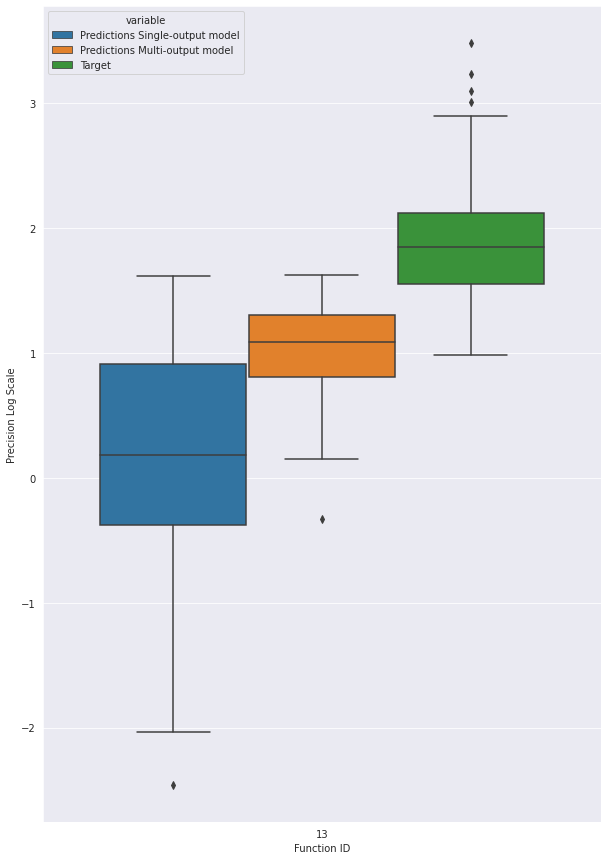

In [ ]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_f_id_1_melted)

In [ ]:
alt.Chart(single_multi_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Precision Log Scale:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

## Log Precision

In [ ]:
single_multi_log_precision_df_melted.replace("log_Precision_prediction_multitarget", 'Log Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_melted.replace("log_Precision_prediction_singletarget", 'Log Predictions Single-output model', inplace=True)
single_multi_log_precision_df_melted.replace("log_Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_precision_df_melted

,Function ID,variable,Log Precision,Log Precision Log Scale
0,10,Predictions Single-output model,125.714870,4.834016
1,11,Predictions Single-output model,2.760320,1.015347
2,12,Predictions Single-output model,118.131110,4.771795
3,13,Predictions Single-output model,1.210913,0.191375
4,14,Predictions Single-output model,1.515805,0.415946
...,...,...,...,...
3595,5,Target,0.000000,-inf
3596,6,Target,0.025452,-3.670945
3597,7,Target,0.000000,-inf
3598,8,Target,1.988712,0.687487


In [ ]:
single_multi_log_precision_df_melted.columns = ['Function ID', 'variable', 'Log Precision']

In [ ]:
alt.Chart(
    single_multi_log_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Log Precision:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

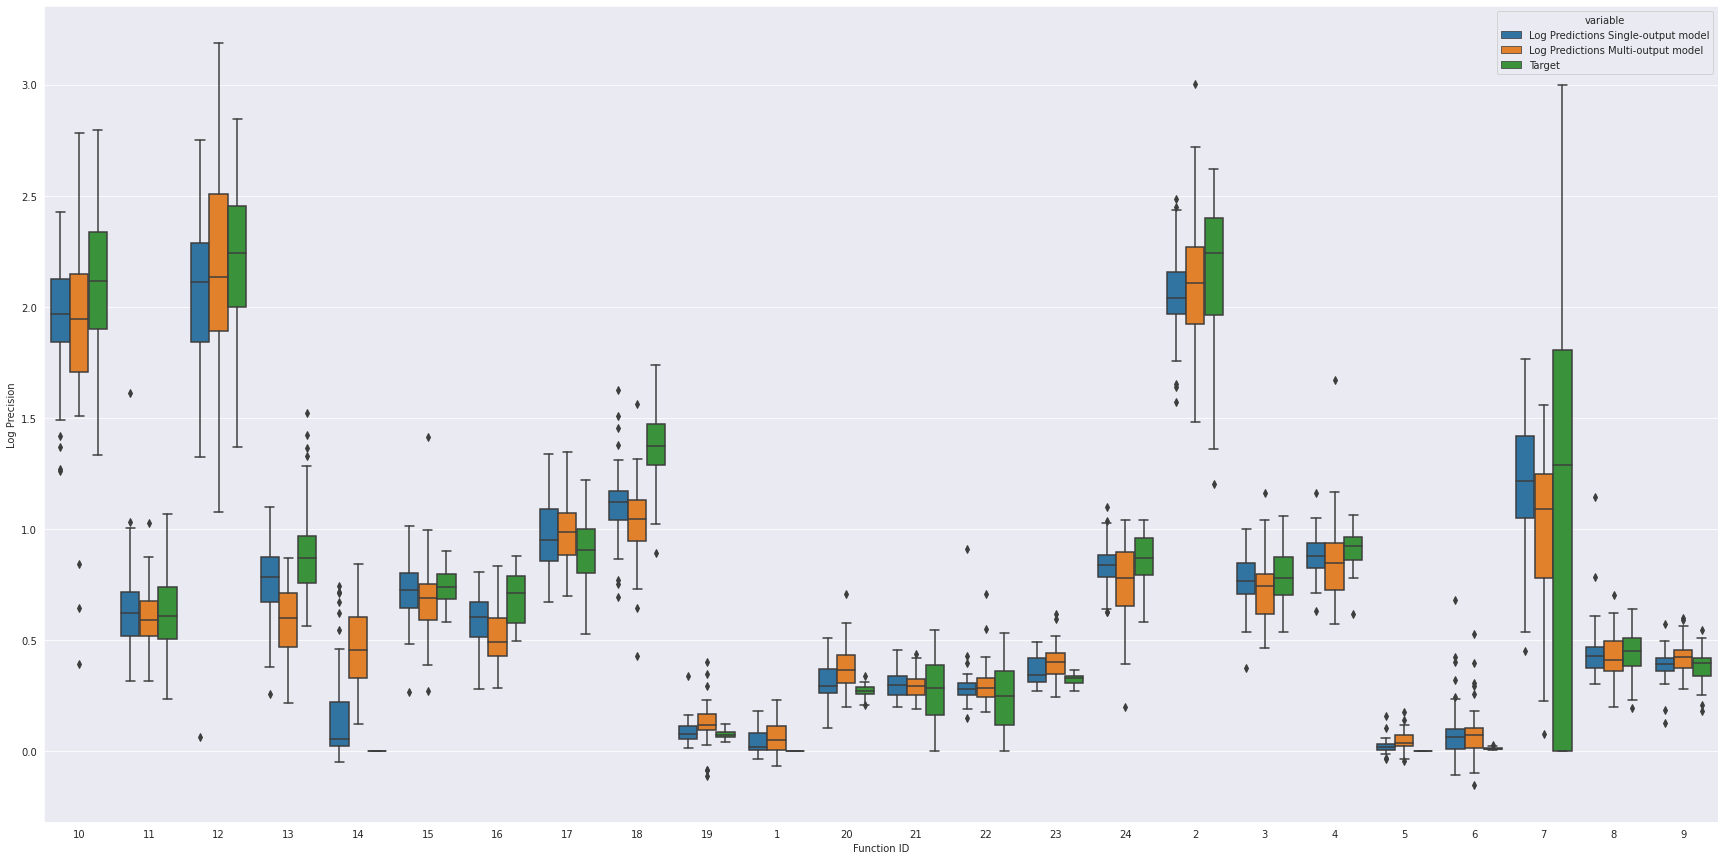

In [ ]:
a4_dims = (30, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_melted)

### Precision for a given function

In [ ]:
f_id = '4'

In [ ]:
single_multi_log_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == f_id][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]

In [ ]:
single_multi_log_precision_df_f_id_1_melted = pd.melt(single_multi_log_precision_df_f_id_1, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [ ]:
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_log_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Log Precision']

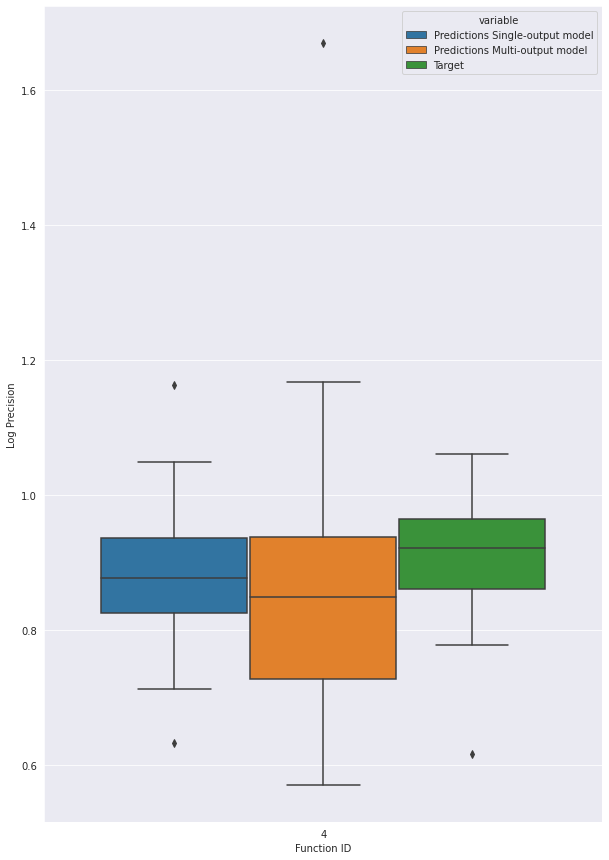

In [ ]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_f_id_1_melted)

In [ ]:
alt.Chart(single_multi_log_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Log Precision:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

### Precision for a given function

In [ ]:
f_id = '13'

In [ ]:
single_multi_log_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == f_id][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]

In [ ]:
single_multi_log_precision_df_f_id_1_melted = pd.melt(single_multi_log_precision_df_f_id_1, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [ ]:
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_real", 'Target', inplace=True)

In [ ]:
single_multi_log_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Log Precision']

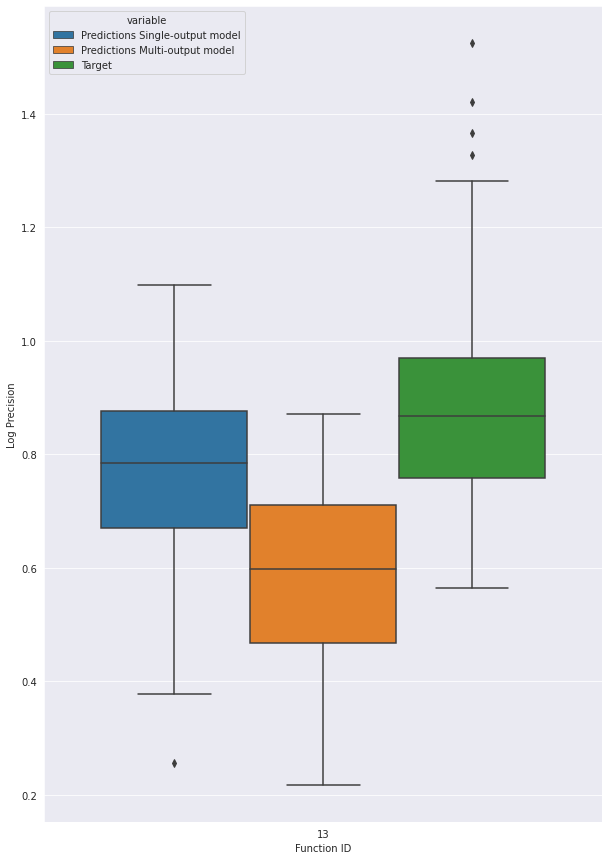

In [ ]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_f_id_1_melted)

In [ ]:
alt.Chart(single_multi_log_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Log Precision:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

# Export

## Shap to CSV

### Multi Model

In [ ]:
for i in range(50):
  model_multi = keras.models.load_model(f"{models_folder}{multi_target_folder}{regression}model_fold_no_{i}_alg_no_{algorithm_no}")

  X_train, y_train, X_test, y_test = get_data(algorithm_no, i)

  f_id_dict, asd = get_dictonary_function_id_with_index(X_train)

  explainer = shap.DeepExplainer(model_multi, np.array(X_train))

  shap_values = explainer.shap_values(np.array(X_train))

  file_name_precision_alg_level = shap_algorithm_level_folder_multi_precision + f'precision_shaps_fold_no_{i}.csv'
  file_name_log_precision_alg_level = shap_algorithm_level_folder_multi_log_precision + f'log_precision_shaps_fold_no_{i}.csv'
  precision_shaps_alg_level = pd.DataFrame(shap_values[0], columns=X_train.columns)
  log_precision_shaps_alg_level = pd.DataFrame(shap_values[1], columns=X_train.columns)
  precision_shaps_alg_level.to_csv(file_name_precision_alg_level, index=False)
  log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level, index=False)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    file_name_precision = shap_function_level_folder_multi_precision + f'function_{f_id}_precision_shaps_fold_no_{i}.csv'
    file_name_log_precision = shap_function_level_folder_multi_log_precision + f'function_{f_id}_log_precision_shaps_fold_no_{i}.csv'
    shap_values = explainer.shap_values(X = np.array(X_train.iloc[f_id_dict.get(str(f_id)), :]))
    precision_shaps = pd.DataFrame(shap_values[0], columns=X_train.columns)
    log_precision_shaps = pd.DataFrame(shap_values[1], columns=X_train.columns)
    precision_shaps.to_csv(file_name_precision, index=False)
    log_precision_shaps.to_csv(file_name_log_precision, index=False)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the

### Single Model

#### Precision

In [ ]:
for i in range(50):
  model_single_precision = keras.models.load_model(f"{models_folder}{single_output_folder}{regression}model_fold_no_{i}_alg_no_{algorithm_no}_label_Precision")

  X_train, y_train, X_test, y_test = get_data(algorithm_no, i)

  f_id_dict, asd = get_dictonary_function_id_with_index(X_train)

  explainer = shap.DeepExplainer(model_single_precision, np.array(X_train))

  shap_values = explainer.shap_values(np.array(X_train))

  file_name_precision_alg_level = shap_algorithm_level_folder_single_precision + f'precision_shaps_fold_no_{i}.csv'
  #file_name_log_precision_alg_level = shap_algorithm_level_folder_multi_log_precision + f'log_precision_shaps.csv'
  precision_shaps_alg_level = pd.DataFrame(shap_values[0], columns=X_train.columns)
  #log_precision_shaps_alg_level = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
  precision_shaps_alg_level.to_csv(file_name_precision_alg_level)
  #log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    file_name_precision = shap_function_level_folder_single_precision  + f'function_{f_id}_precision_shaps_fold_no_{i}.csv'
    #file_name_log_precision = shap_function_level_folder_multi_log_precision + f'function_{f_id}_log_precision_shaps.csv'
    shap_values = explainer.shap_values(X = np.array(X_train.iloc[f_id_dict.get(str(f_id)), :]))
    precision_shaps = pd.DataFrame(shap_values[0], columns=X_train.columns)
    #log_precision_shaps = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
    precision_shaps.to_csv(file_name_precision, index=False)
    #log_precision_shaps.to_csv(file_name_log_precision)


#### Log Precision

In [ ]:
for i in range(50):
  model_single_log_precision = keras.models.load_model(f"{models_folder}{single_output_folder}{regression}model_fold_no_{i}_alg_no_{algorithm_no}_label_log_Precision")

  X_train, y_train, X_test, y_test = get_data(algorithm_no, i)

  f_id_dict, asd = get_dictonary_function_id_with_index(X_train)

  explainer = shap.DeepExplainer(model_single_log_precision, np.array(X_train))

  shap_values = explainer.shap_values(np.array(X_train))

  #file_name_precision_alg_level = shap_algorithm_level_folder_single_precision + f'precision_shaps.csv'
  file_name_log_precision_alg_level = shap_algorithm_level_folder_single_log_precision  + f'log_precision_shaps_fold_no_{i}.csv'
  #precision_shaps_alg_level = pd.DataFrame(shap_values, columns=model_single_precision.X_train.columns)
  log_precision_shaps_alg_level = pd.DataFrame(shap_values[0], columns=X_train.columns)
  #precision_shaps_alg_level.to_csv(file_name_precision_alg_level)
  log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    #file_name_precision = shap_function_level_folder_single_log_precision   + f'function_{f_id}_precision_shaps.csv'
    file_name_log_precision = shap_function_level_folder_single_log_precision + f'function_{f_id}_log_precision_shaps_fold_no_{i}.csv'
    shap_values = explainer.shap_values(X = np.array(X_train.iloc[f_id_dict.get(str(f_id)), :]))
    #precision_shaps = pd.DataFrame(shap_values, columns=model_single_log_precision.X_train.columns)
    log_precision_shaps = pd.DataFrame(shap_values[0], columns=X_train.columns)
    #precision_shaps.to_csv(file_name_precision, index=False)
    log_precision_shaps.to_csv(file_name_log_precision)


## MAE to Csv

### Function Level

In [ ]:
mae_fid = []
mae_fid_multi = []
mae_fid_single = []
for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == str(i)][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])
    mae_fid_multi.append([i, multi_mae_function])
    mae_fid_single.append([i, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['f_id', 'Multi_output_model_MAE_PRECISION', 'Single_output_model_MAE_PRECISION'])
mae_fid_multi = pd.DataFrame(mae_fid_multi, columns=['f_id', 'MAE'])
mae_fid_single = pd.DataFrame(mae_fid_single, columns=['f_id', 'MAE'])

In [ ]:
file_name_mae_multi_precision = mae_funtion_level_folder_multi_precision + f'function_level_mae.csv'
file_name_mae_single_precision = mae_funtion_level_folder_single_precision  + f'function_level_mae.csv'

In [ ]:
mae_fid_multi.to_csv(file_name_mae_multi_precision, index=False)
mae_fid_single.to_csv(file_name_mae_single_precision, index=False)

In [ ]:
mae_fid = []
mae_fid_multi = []
mae_fid_single = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == str(i)][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])
    mae_fid_multi.append([i, multi_mae_function])
    mae_fid_single.append([i, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['f_id', 'Multi_output_model_MAE_LOG_PRECISION', 'Single_output_model_MAE_LOG_PRECISION'])
mae_fid_multi = pd.DataFrame(mae_fid_multi, columns=['f_id', 'MAE'])
mae_fid_single = pd.DataFrame(mae_fid_single, columns=['f_id', 'MAE'])

In [ ]:
file_name_mae_multi_precision = mae_funtion_level_folder_multi_log_precision  + f'function_level_mae.csv'
file_name_mae_single_precision = mae_funtion_level_folder_single_log_precision   + f'function_level_mae.csv'

In [ ]:
mae_fid_multi.to_csv(file_name_mae_multi_precision, index=False)
mae_fid_single.to_csv(file_name_mae_single_precision, index=False)

### Fold Level

In [ ]:
mae_precision_single = mae_merged_renamed[['Fold', 'Precision_single_output_mae']]
mae_log_precision_single = mae_merged_renamed[['Fold', 'log_Precision_single_output_mae']]
mae_precision_multi = mae_merged_renamed[['Fold', 'Precision_multioutput_mae']]
mae_log_precision_multi = mae_merged_renamed[['Fold', 'log_Precision_multioutput_mae']]

In [ ]:
mae_precision_multi_file_name = mae_algorithm_level_folder_multi_precision  + f'fold_level_mae.csv'
mae_log_precision_multi_file_name = mae_algorithm_level_folder_multi_log_precision + f'fold_level_mae.csv'
mae_precision_single_file_name = mae_algorithm_level_folder_single_precision + f'fold_level_mae.csv'
mae_log_precision_single_file_name = mae_algorithm_level_folder_single_log_precision + f'fold_level_mae.csv'

In [ ]:
mae_precision_multi.to_csv(mae_precision_multi_file_name)
mae_log_precision_multi.to_csv(mae_log_precision_multi_file_name)
mae_precision_single.to_csv(mae_precision_single_file_name)
mae_log_precision_single.to_csv(mae_log_precision_single_file_name)

In [ ]:
drive.flush_and_unmount()

In [ ]:
# If you are using Google Colab uncomment next line

# drive.flush_and_unmount()